In [1]:
import pandas as pd
import numpy as np
import geojson

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from ast import literal_eval
import collections

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

In [2]:
city = 'venezia'

### raw, original files with all datapoints
listings_link = 'data/' + city + '/listings.csv.gz'
#reviews_link = 'data/' + city + '/reviews.csv.gz'
#calendar_link = 'data/' + city + '/calendar.csv.gz'

### shortened summary of listings: just a few main features from the original file
#listings_sum_link = 'data/' + city + '/listings.csv'

### neighborhood information
neighborhoods_link = 'data/' + city + '/neighbourhoods.csv'
neighborhoods_gjson_link = 'data/' + city + '/neighbourhoods.geojson'

In [3]:
### read 'big' gzipped files
listings = pd.read_csv(listings_link, compression = 'gzip', error_bad_lines = False)
#reviews = pd.read_csv(reviews_link, compression = 'gzip', error_bad_lines = False)
#calendar = pd.read_csv(calendar_link, compression = 'gzip', error_bad_lines = False)

### read neighborhhood info
neighborhoods = pd.read_csv(neighborhoods_link)

### read summarized data of listings
#listings_summarized = pd.read_csv(listings_sum_link)

### read geojson with neighborhood geo data
with open(neighborhoods_gjson_link) as f:
    neighborhoods_gjson = geojson.load(f)

### Check files

Listings summarized is just a few of the original features, plus the grouped neighborhood. I'll go over all features and select the necessary ones and do feature engineering manually

In [4]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6623,https://www.airbnb.com/rooms/6623,20210806113017,2021-08-06,Venice Blue on Canal apartment,"I'm thrilled to share my ""Blue on Venice Canal...",Close by is the Frari Church (known as Tiziano...,https://a0.muscache.com/pictures/492258/834683...,15016,https://www.airbnb.com/users/show/15016,...,4.85,4.96,4.92,NaN,f,3,3,0,0,1.55
1,6624,https://www.airbnb.com/rooms/6624,20210806113017,2021-08-06,Venice garden charme and canal view!,I'm thrilled to share my apartment with garden...,We are in the middle of a residential area cal...,https://a0.muscache.com/pictures/65440024/a564...,15016,https://www.airbnb.com/users/show/15016,...,4.85,4.93,4.92,NaN,f,3,3,0,0,0.68


In [5]:
#listings_summarized.head(2)

In [6]:
# reviews.head(2)

Calendar includes daily prices for up to a year. Monthly aggregation, or just simple overall median can be taken..

In [7]:
#calendar.head(2)

Neighborhood groups will be used to reduce cardinality of neighborhood feature

In [8]:
neighborhoods.head(2)

,neighbourhood_group,neighbourhood
0,Isole,Alberoni
1,Isole,Burano


In [9]:
print(neighborhoods['neighbourhood_group'].nunique())
print(neighborhoods['neighbourhood'].nunique())

2
114


## 1 Clean the calendar

In [10]:
#calendar.head(2)

In [11]:
#calendar = calendar[calendar['price'].notnull()]

In [12]:
# calendar['price'] = calendar['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
# calendar['adjusted_price'] = calendar['adjusted_price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

# calendar = calendar[calendar['price'] != 0] # no price means no target value
# calendar.drop('adjusted_price', 1, inplace = True) # dont want to incorporate promotions, etc...

#### Aggregating listing prices monthly

In [13]:
# calendar['year'] = pd.to_datetime(calendar['date']).dt.year
# calendar['month'] = pd.to_datetime(calendar['date']).dt.month

In [14]:
# price_calendar = calendar.groupby(['listing_id', 'year', 'month']).agg({'price' : 'median', 'minimum_nights' : 'median', 'maximum_nights' : 'median'}).reset_index()
# price_calendar.head(3)

The calendar may not be used afterall, the listings file has a price point for the day of scraping. That price is going to be predicted with the available, respective-in-time features

## 2 Clean listings

In [15]:
to_drop = ['scrape_id', 'last_scraped', 'picture_url', 
           'host_id', 'host_thumbnail_url', 'host_picture_url',
           'calendar_last_scraped', 'host_location', 'host_verifications', 'property_type']

# will keep until modeling: listing_url, host_url, host_name

listings.drop(to_drop, 1, inplace = True)

#### Check missing ratios

In [16]:
check_nan = (listings.isnull().sum() / listings.shape[0])[(listings.isnull().sum() / listings.shape[0]) > 1/3]
check_nan

neighborhood_overview    0.355480
host_about               0.445325
host_neighbourhood       0.390588
neighbourhood            0.355480
bathrooms                1.000000
calendar_updated         1.000000
license                  0.864980
dtype: float64

In [17]:
to_drop = check_nan.index
print(to_drop)

Index(['neighborhood_overview', 'host_about', 'host_neighbourhood',
       'neighbourhood', 'bathrooms', 'calendar_updated', 'license'],
      dtype='object')


Create features indicating missing or filled info:
- host has description
- neighborhood has description

Delete remaining features with many NaNs

In [18]:
listings['description_host'] = listings['host_about'].apply(lambda x: 1 if x is np.nan else 0)
listings['description_neighbourhood'] = listings['neighborhood_overview'].apply(lambda x: 1 if x is np.nan else 0)

listings.drop(to_drop, 1, inplace = True)

#### Check True/False features

In [19]:
true_false_columns = listings.select_dtypes('O').loc[:, listings.nunique() == 2].columns.tolist()
true_false_columns = [i for i in true_false_columns if i != 'neighbourhood_group_cleansed']
print(true_false_columns)

['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']


In [20]:
listings[true_false_columns].isnull().sum()

host_is_superhost         230
host_has_profile_pic      230
host_identity_verified    230
has_availability            0
instant_bookable            0
dtype: int64

In [21]:
listings = listings[listings['host_is_superhost'].notnull()]

In [22]:
for col in true_false_columns:
    listings[col] = listings[col].apply(lambda x: 1 if x == 't' else 0)

#### Check categorical features

In [23]:
listings.describe(include = 'O').T

,count,unique,top,freq
listing_url,7717,7717,https://www.airbnb.com/rooms/12419184,1
name,7717,7557,Apartment in the heart of Venice,6
description,7581,7230,"Room with standard double bed, wardrobe and eq...",17
host_url,7717,3648,https://www.airbnb.com/users/show/2634978,131
host_name,7717,1333,Andrea,151
host_since,7717,2201,2012-06-14,136
host_response_time,6226,4,within an hour,5055
host_response_rate,6226,49,100%,4530
host_acceptance_rate,6196,72,100%,3755
neighbourhood_cleansed,7717,57,Cannaregio,1503


The following features need to be converted to floats:

- host since (years ago)
- host response rate (0-1 float)
- host acceptance rate (0-1 float)
- bathrooms (count)
- price
- first review (years ago)
- last review (years ago)

The following features will need to be 'exploded' / 'one-hot-encoded':
- amenities (for all amenities a has_amenity true/false feature will be created

The following features will be grouped to reduce cardinality:
- property type
- neighborhoods

Neighbourhoods

In [24]:
top_neighborhoods = listings['neighbourhood_cleansed'].value_counts().head(10).index.tolist()
print(top_neighborhoods)

['Cannaregio', 'Castello', 'San Marco', 'San Polo', 'Dorsoduro', 'Santa Croce', 'Piave 1860', 'Lido', 'San Lorenzo XXV Aprile', 'Marghera']


In [25]:
if neighborhoods['neighbourhood_group'].nunique() == 0 or neighborhoods['neighbourhood_group'].nunique() >= 3:  
    
    if listings['neighbourhood_cleansed'].nunique() <= 10:        
        listings['neighbourhood_cleansed_grouped'] = listings['neighbourhood_cleansed'].copy()
        
    else:
        listings['neighbourhood_cleansed_grouped'] = listings['neighbourhood_cleansed'].apply(lambda x: x if x in top_neighborhoods else 'Other')

else:
    
    listings['neighbourhood_cleansed_grouped'] = listings['neighbourhood_cleansed'].apply(lambda x: x if x in top_neighborhoods else 'Other')
    
    if 'neighbourhood_group_cleansed' in listings.columns:
        
        for i in listings['neighbourhood_group_cleansed'].unique():
    
            listings.loc[(listings['neighbourhood_cleansed_grouped'] == 'Other') &
                         (listings['neighbourhood_group_cleansed'] == i), 'neighbourhood_cleansed_grouped'] = 'Other in ' + i

Everything else

In [26]:
today_date = pd.to_datetime('2021-08-30')

listings['host_since_years'] = (today_date - pd.to_datetime(listings['host_since'])).dt.days / 365
listings['first_review_years'] = (today_date - pd.to_datetime(listings['first_review'])).dt.days / 365
listings['last_review_years'] = (today_date - pd.to_datetime(listings['last_review'])).dt.days / 365

if 'host_response_rate' in listings.columns:
    listings['host_response_rate'] = listings['host_response_rate'].apply(lambda x: float(x.replace('%', '')) / 100 if type(x) == str else x)

if 'host_acceptance_rate' in listings.columns:
    listings['host_acceptance_rate'] = listings['host_acceptance_rate'].apply(lambda x: float(x.replace('%', '')) / 100 if type(x) == str else x)

listings['price'] = listings['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

bath_replace = {'Shared half-bath' : '0.5 shared baths', 
                'Half-bath' : '0.5 baths',
                'Private half-bath' : '0.5 baths'}
listings['bathrooms_text'] = listings['bathrooms_text'].replace(bath_replace)
listings['bathrooms_are_shared'] = listings['bathrooms_text'].apply(lambda x: 1 if 'shared' in str(x).lower() else 0)
listings['bathrooms_count'] = listings['bathrooms_text'].apply(lambda x: float(str(x).split(' ')[0]))

host_response_time_replace = {'within an hour' : 'within_hour', 'within a few hours' : 'within_few_hours', 'within a day' : 'within_day', 'a few days or more' : 'few_days'}
if 'host_response_time' in listings.columns:
    listings['host_response_time'] = listings['host_response_time'].replace(host_response_time_replace)

room_type_replace = {'Entire home/apt' : 'entire_place', 'Private room' : 'private_room', 'Hotel room' : 'hotel_room', 'Shared room' : 'shared_room'}
listings['room_type'] = listings['room_type'].replace(room_type_replace)

listings.drop(['first_review', 'last_review', # host_since can be used to analyze host registrations
               'bathrooms_text'], 1, inplace = True)

In [27]:
listings.describe(include = 'O').T

,count,unique,top,freq
listing_url,7717,7717,https://www.airbnb.com/rooms/12419184,1
name,7717,7557,Apartment in the heart of Venice,6
description,7581,7230,"Room with standard double bed, wardrobe and eq...",17
host_url,7717,3648,https://www.airbnb.com/users/show/2634978,131
host_name,7717,1333,Andrea,151
host_since,7717,2201,2012-06-14,136
host_response_time,6226,4,within_hour,5055
neighbourhood_cleansed,7717,57,Cannaregio,1503
neighbourhood_group_cleansed,7717,2,Isole,6374
room_type,7717,4,entire_place,5820


And now to treat the amenities

In [28]:
listings['amenities'] = listings['amenities'].apply(lambda x: literal_eval(x))

In [29]:
len(set().union(*listings['amenities']))

603

In [30]:
def consolidate_amenities_lists(amenities_list):
    
    consolidated_list = ['TV' if 'tv' in str(i).lower() else i for i in amenities_list]
    consolidated_list = ['Free parking' if ('free' in str(i).lower() and 'parking' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Free parking' if ('complimentary' in str(i).lower() and 'parking' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Free parking' if ('free' in str(i).lower() and 'garage' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Paid parking' if ('paid' in str(i).lower() and 'parking' in str(i).lower())else i for i in consolidated_list]
    consolidated_list = ['Air conditioning' if 'air conditioning' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Clothing storage' if 'clothing storage' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'refrigerator' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'fridge' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Washer' if 'washer' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Oven' if 'oven' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Soap' if 'soap' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Stove' if 'stove' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Shower' if 'shower' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Bath' if 'bath' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'cooler' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Shampoo' if 'shampoo' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Conditioner' if 'conditioner' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Sound system' if 'sound system' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Essentials' if 'essentials' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Children stuff' if 'children' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Workspace' if 'workspace' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Workspace' if 'office' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Dryer' if 'Dryer' in str(i) else i for i in consolidated_list]
    consolidated_list = ['Dryer' if ('free' in str(i).lower() and 'dryer' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Dryer' if ('paid' in str(i).lower() and 'dryer' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'wifi' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'ethernet' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'internet' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Heating' if 'heating' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Game console' if 'game console' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Gym' if 'gym' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Coffee maker' if 'coffee' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Coffee maker' if 'espresso' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Fireplace' if 'fireplace' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Fireplace' if 'fire pit' in str(i).lower() else i for i in consolidated_list]
        
    consolidated_list = list(collections.OrderedDict.fromkeys(consolidated_list))
    
    return consolidated_list

In [31]:
listings['amenities'] = listings['amenities'].apply(lambda x: consolidate_amenities_lists(x))

In [32]:
len(set().union(*listings['amenities']))

158

In [33]:
set().union(*listings['amenities'])

{'Air conditioning',
 'Airport shuttle',
 'BBQ grill',
 'Baby monitor',
 'Baby safety gates',
 'Babysitter recommendations',
 'Backyard',
 'Baking sheet',
 'Balcony',
 'Barbecue utensils',
 'Bath',
 'Beachfront',
 'Bed linens',
 'Bed sheets and pillows',
 'Bedroom comforts',
 'Bidet',
 'Board games',
 'Boat slip',
 'Bottled water',
 'Bread maker',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Building staff',
 'Carbon monoxide alarm',
 'Ceiling fan',
 'Changing table',
 'Children stuff',
 'Cleaning before checkout',
 'Cleaning products',
 'Clothing storage',
 'Coffee maker',
 'Complimentary breakfast',
 'Complimentary breakfast buffet',
 'Concierge',
 'Conditioner',
 'Cooking basics',
 'Courtyard',
 'Crib',
 'Desk',
 'Dining area',
 'Dining table',
 'Dishes and silverware',
 'Dryer',
 'Drying rack for clothing',
 'EV charger',
 'Elevator',
 'Essentials',
 'Extra pillows and blankets',
 'Fenced garden or backyard',
 'Fire extinguisher',
 'Fireplace',
 'First aid kit',
 'Formal d

After consolidation check top 20 amenities, keep them for one hot encoding

In [34]:
select_top_amenities = 30

flattened_amenities = [item for sublist in listings['amenities'].tolist() for item in sublist]
amenities_count = collections.Counter(flattened_amenities)
amenities_count.most_common(select_top_amenities)

[('Heating', 7483),
 ('Wifi', 7333),
 ('Essentials', 7304),
 ('Hair dryer', 7202),
 ('Long term stays allowed', 6876),
 ('Hangers', 6541),
 ('Air conditioning', 6409),
 ('TV', 6396),
 ('Kitchen', 6271),
 ('Hot water', 5864),
 ('Shampoo', 5359),
 ('Iron', 5283),
 ('Washer', 5143),
 ('Refrigerator', 5026),
 ('Workspace', 5003),
 ('Dishes and silverware', 4936),
 ('Cooking basics', 4581),
 ('Bed linens', 4153),
 ('Coffee maker', 4031),
 ('Stove', 3680),
 ('Microwave', 3632),
 ('Oven', 3024),
 ('Host greets you', 2942),
 ('Extra pillows and blankets', 2766),
 ('Private entrance', 2566),
 ('Luggage dropoff allowed', 2249),
 ('First aid kit', 2247),
 ('Fire extinguisher', 2130),
 ('Smoke alarm', 2021),
 ('Carbon monoxide alarm', 1733)]

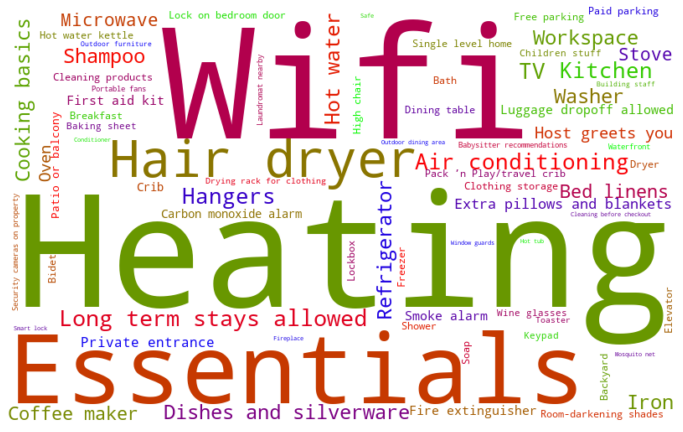

In [35]:
wordcloud = WordCloud(min_word_length = 3, background_color = 'white', width = 800, height = 500, 
                      max_words = 100, random_state = 20202020, min_font_size = 7, prefer_horizontal = 3/4,
                      colormap = 'brg')
wordcloud.generate_from_frequencies(amenities_count)

plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [36]:
top_amenities = [i[0] for i in amenities_count.most_common(select_top_amenities)]
#top_amenities.extend(['Pets allowed', 'Self check-in'])

print('Top amenities included: ', top_amenities)

Top amenities included:  ['Heating', 'Wifi', 'Essentials', 'Hair dryer', 'Long term stays allowed', 'Hangers', 'Air conditioning', 'TV', 'Kitchen', 'Hot water', 'Shampoo', 'Iron', 'Washer', 'Refrigerator', 'Workspace', 'Dishes and silverware', 'Cooking basics', 'Bed linens', 'Coffee maker', 'Stove', 'Microwave', 'Oven', 'Host greets you', 'Extra pillows and blankets', 'Private entrance', 'Luggage dropoff allowed', 'First aid kit', 'Fire extinguisher', 'Smoke alarm', 'Carbon monoxide alarm']


In [37]:
def reduce_amenities(amenities_list):
    
    reduced_amenities = ['amenity_' + '_'.join(i.split()).lower() for i in amenities_list if i in top_amenities]
    
    return sorted(reduced_amenities)

In [38]:
listings['amenities'] = listings['amenities'].apply(lambda x: reduce_amenities(x))

In [39]:
for amenity_col in list(set().union(*listings['amenities'])):       
    listings[amenity_col] = listings['amenities'].apply(lambda x: 1 if amenity_col in x else 0)
    
listings.drop(['amenities'], 1, inplace = True)

#### Listing name and description may also be helpful. 
- Number of words in name
- Number of words in description
- Maybe some one hot encoding of certain words (luxurious, spacious, etc...)

In [40]:
listings[['name', 'description']].head()

,name,description
0,Venice Blue on Canal apartment,"I'm thrilled to share my ""Blue on Venice Canal..."
1,Venice garden charme and canal view!,I'm thrilled to share my apartment with garden...
2,Venice home to relax and emotions,I'm thrilled to share my home to guests coming...
3,Charming room with balcony close to S. Mark's,"Few steps from Saint Mark square, on a picture..."
4,Historical Luxury Apartment on Calm Sunny Canal,Descend a spiral staircase to discover an apar...


Clean text from non alphabetic characters, stopwords

In [41]:
def process_text(text, remove_stopwords = False):    
    text = text.lower()
    
    # clean text
    text = re.compile('<.*?>').sub(' ', text) # html tags
    text = re.compile('[^a-z]').sub(' ', text) # nonletters      
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces
    
    if remove_stopwords == True:
        
        # remove stopwords
        text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    
    return text

In [42]:
listings['description_cleaned'] = listings['description'].apply(lambda x: process_text(x) if isinstance(x, float) == False else x)
listings['name_cleaned'] = listings['name'].apply(lambda x: process_text(x) if isinstance(x, float) == False else x)

In [43]:
listings['name_cleaned_length'] = listings['name_cleaned'].apply(lambda x: len(x.split()) if isinstance(x, float) == False else 0)
listings['description_cleaned_length'] = listings['description_cleaned'].apply(lambda x: len(x.split()) if isinstance(x, float) == False else 0)

In [44]:
listings['name_cleaned_no_stopwords'] = listings['name'].apply(lambda x: process_text(x, remove_stopwords = True) if isinstance(x, float) == False else x)

In [45]:
word_vectorizer = CountVectorizer(ngram_range = (1, 2), analyzer = 'word')
sparse_matrix = word_vectorizer.fit_transform(listings['name_cleaned_no_stopwords'].astype(str))
frequencies = sum(sparse_matrix).toarray()[0]

word_counts = pd.DataFrame(frequencies, index = word_vectorizer.get_feature_names(), columns = ['frequency'])

In [46]:
word_counts.sort_values('frequency', ascending = False).head(20)

,frequency
venice,1550
apartment,1419
ca,831
room,806
san,662
view,587
canal,579
marco,552
venezia,545
san marco,457


Based on unigrams and ngrams I can create a couple of feature indicating if something is mentioned in the name or description

In [47]:
touristy_words = ['rialto', 'canal', 'marco'] # for venezia
# touristy_words = ['sagrada', 'familia', 'gracia'] # for barcelona
# touristy_words = ['duomo', 'center', 'centro', 'view', 'heart'] # for firenze

# touristy_words = ['center', 'central', 'nbrunn', 'sch'] # for vienna

pattern = '|'.join(touristy_words)

listings['name_touristy'] = 0
listings.loc[(listings['name_cleaned'].notnull() & 
              listings['name_cleaned'].str.contains(pattern)), 'name_touristy'] = 1

In [48]:
listings.drop(['name_cleaned', 'description_cleaned', 'name_cleaned_no_stopwords'], 1, inplace = True)

#### Check numerical features

In [49]:
listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm',
               'minimum_maximum_nights', 'maximum_maximum_nights', 'host_listings_count', 'maximum_nights', 
               'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], 1, inplace = True)

Drop items above 99th percentile

In [50]:
check_99th_perc = ['host_total_listings_count', 'bedrooms', 'beds', 'price', 'bathrooms_count']

perc_99_values = listings[check_99th_perc].describe(exclude = ['O'], 
                                           percentiles = [.99])\
                                          .T['99%']\
                                          .sort_values(ascending = False)

perc_99_values

price                        839.36
host_total_listings_count    129.00
beds                           8.00
bedrooms                       5.00
bathrooms_count                4.00
Name: 99%, dtype: float64

In [51]:
print(listings.shape)

for num_col in perc_99_values.index:
    
    perc_99_value = perc_99_values[num_col]
    listings = listings.loc[listings[num_col] <= perc_99_value]
    
print(listings.shape)

(7717, 82)
(7283, 82)


Check skewness and drop features based on that

In [55]:
skewness = listings.skew(skipna = True)
skewness = skewness[skewness.abs() >= 5]

print(skewness)

skewness = [i for i in skewness.index if i != 'review_scores_rating'] # will be the target, no matter the skewness
listings.drop(skewness, 1, inplace = True)

host_has_profile_pic          -16.650320
minimum_nights                 37.362552
has_availability              -16.650320
review_scores_rating           -5.480217
review_scores_checkin          -5.507301
review_scores_communication    -5.115671
review_scores_location         -6.566216
amenity_heating                -5.617777
dtype: float64


Shouldnt have 0 or half a bathroom

In [57]:
if 'bathrooms_count' in listings.columns:
    listings = listings[listings['bathrooms_count'] >= 1]

The following numerical features could be binned to groups
- bedrooms
- bathrooms

In [58]:
# listings['bedrooms'] = listings['bedrooms'].apply(lambda x: '1_bedroom' if x == 1 else ('2_bedrooms' if x == 2 else '2_plus_bedrooms'))
# listings['bathrooms_count'] = listings['bathrooms_count'].apply(lambda x: '1_bathroom' if x == 1 else ('1.5_bathrooms' if x == 1.5 else ('2_bathrooms' if x == 2 else '2_plus_bathrooms')))

#### Check int features

In [59]:
# listings['accommodates'] = listings['accommodates'].apply(lambda x: '1' if x == 1 else ('2' if x == 2 else ('3' if x == 3 else ('4' if x == 4 else ('5' if x == 5 else '5_plus')))))

Check balances of 1/0 (true/false) features. Drop features with overwhelming majorities (>90% in one class)

In [60]:
true_false_features = listings.select_dtypes('int64').max()[listings.select_dtypes('int64').max() == 1].index.tolist()
print(true_false_features)

['host_is_superhost', 'host_identity_verified', 'instant_bookable', 'description_host', 'description_neighbourhood', 'bathrooms_are_shared', 'amenity_hot_water', 'amenity_host_greets_you', 'amenity_carbon_monoxide_alarm', 'amenity_cooking_basics', 'amenity_workspace', 'amenity_smoke_alarm', 'amenity_private_entrance', 'amenity_coffee_maker', 'amenity_iron', 'amenity_luggage_dropoff_allowed', 'amenity_essentials', 'amenity_bed_linens', 'amenity_fire_extinguisher', 'amenity_hair_dryer', 'amenity_oven', 'amenity_extra_pillows_and_blankets', 'amenity_stove', 'amenity_first_aid_kit', 'amenity_tv', 'amenity_washer', 'amenity_wifi', 'amenity_shampoo', 'amenity_dishes_and_silverware', 'amenity_hangers', 'amenity_refrigerator', 'amenity_kitchen', 'amenity_microwave', 'amenity_long_term_stays_allowed', 'amenity_air_conditioning', 'name_touristy']


In [61]:
listings[true_false_features].describe(percentiles = [.01, .1, .25, .5, .75, .9, .99]).T.drop(['mean', 'std'], 1).astype(int)

,count,min,1%,10%,25%,50%,75%,90%,99%,max
host_is_superhost,7234,0,0,0,0,0,1,1,1,1
host_identity_verified,7234,0,0,0,1,1,1,1,1,1
instant_bookable,7234,0,0,0,0,1,1,1,1,1
description_host,7234,0,0,0,0,0,1,1,1,1
description_neighbourhood,7234,0,0,0,0,0,1,1,1,1
bathrooms_are_shared,7234,0,0,0,0,0,0,0,1,1
amenity_hot_water,7234,0,0,0,1,1,1,1,1,1
amenity_host_greets_you,7234,0,0,0,0,0,1,1,1,1
amenity_carbon_monoxide_alarm,7234,0,0,0,0,0,0,1,1,1
amenity_cooking_basics,7234,0,0,0,0,1,1,1,1,1


In [62]:
L = listings.shape[0]
true_false_features_balance = {}

for i in true_false_features:
    
    n_true = listings[i].sum()
    n_false = L - n_true
    
    if n_true / L >= 0.9 or n_false / L >= 0.9:
        
        true_false_features_balance[i] = n_true / L

true_false_features_balance

{'bathrooms_are_shared': 0.07893281725186618,
 'amenity_essentials': 0.9496820569532762,
 'amenity_hair_dryer': 0.9423555432679016,
 'amenity_wifi': 0.9514791263478021}

In [63]:
listings.drop(true_false_features_balance.keys(), 1, inplace = True) 

### Main cleaning is now complete: final overview of listing dataset

In [64]:
listings.dtypes.value_counts()

int64      43
float64    17
object     11
dtype: int64

In [65]:
listings.isnull().sum()[listings.isnull().sum() > 0]

description                   103
host_response_time           1394
host_response_rate           1394
host_acceptance_rate         1418
review_scores_rating         1121
review_scores_accuracy       1158
review_scores_cleanliness    1158
review_scores_value          1159
reviews_per_month            1121
first_review_years           1121
last_review_years            1121
dtype: int64

In [66]:
check_to_drop = ['review_scores_rating', 'review_scores_value', 'review_scores_accuracy'] 

for i in check_to_drop:
    if i in listings.columns:
        listings = listings[listings[i].notnull()]

In [67]:
listings.isnull().sum()[listings.isnull().sum() > 0]

description               45
host_response_time      1055
host_response_rate      1055
host_acceptance_rate    1051
dtype: int64

Changes to be made after data analysis (next notebook):
- drop
    - 'neighbourhood_group_cleansed'
    - longitude
    - latitude
    
- treat
    - NaNs for host_response_time, rate and acceptance rate features. GBMs can take care of it, linreg needs manual adj

### Reviews

In [68]:
# reviews[(reviews['reviewer_name'] == 'Kristof')] # &
# #         (reviews['listing_id'] == 19493233)]['comments'][328156]

Reviews data for now will not be used. Listings data has ratings, comment counts and other feedback related info

### Save cleaned file for further analysis

In [69]:
listings.to_csv('data/' + city + '/listings_cleaned.csv', index = False)